# Workflow for importing, processing, aggregating, and importing CORDEX ensemble stats for max temperature

In [1]:
import json
import pandas as pd
import geopandas as gpd
import xarray as xr
from dhis2eo.data.cds import cordex
from dhis2_client import DHIS2Client
from dhis2eo.integrations.pandas import dataframe_to_dhis2_json

In [22]:
# Params
DHIS2_BASE_URL = 'https://climate.im.dhis2.org/climate-projections-42'
DHIS2_USERNAME = 'admin'
DHIS2_PASSWORD = 'district'
DHIS2_ORG_UNIT_LEVEL = 2

In [23]:
# Connect
client = DHIS2Client(
    base_url=DHIS2_BASE_URL,
    username=DHIS2_USERNAME,
    password=DHIS2_PASSWORD,
)
info = client.get_system_info()

# Check if everything is working.
# You should see your current DHIS2 version info.
print("Current DHIS2 version:", info["version"])

### Get org units GeoJSON from DHIS2
org_units_geojson = client.get_org_units_geojson(level=DHIS2_ORG_UNIT_LEVEL)

# Convert GeoJSON to geopandas
org_units = gpd.read_file(json.dumps(org_units_geojson))
org_units

Current DHIS2 version: 2.42.3.1


,id,code,name,level,parent,parentGraph,groups,geometry
0,O6uvpzGd5pu,OU_264,Bo,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy]","POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,fdc6uOvgoji,OU_193190,Bombali,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, J40PpdN4Wkk, GGghZsfu7qV]","POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,lc3eMKXaEfw,OU_197385,Bonthe,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy, GGghZsfu7qV]","MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,jUb8gELQApl,OU_204856,Kailahun,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, nlX2VoouN63]","POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,PMa2VCrupOd,OU_211212,Kambia,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, b0EsAxm8Nge, nlX2Vo...","MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,kJq2mPyFEHo,OU_222616,Kenema,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL]","POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,qhqAxPSTUXp,OU_226213,Koinadugu,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Vth0fbpFcsO,OU_233310,Kono,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,jmIPBj66vD6,OU_246990,Moyamba,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, jqBqIXoXpfy]","MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,TEQlaapDQoK,OU_254945,Port Loko,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, b0EsAxm8Nge]","MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


## Download and save to reduced file format

In [6]:
# begin
start_year = 2021
end_year = 2050
dirname = '../test_outputs/cordex'
variables = ["minimum_2m_temperature_in_the_last_24_hours"]
region = 'africa'
resolution = '0_22_degree_x_0_22_degree'
scenarios = ['rcp_2_6', 'rcp_8_5']

files = []
for scenario in scenarios:
    print('Scenario', scenario)
    prefix = f'cordex_temperature_min_{scenario}'
    scenario_models = cordex.MODELS['africa'][resolution][scenario]
    subfiles = cordex.daily.get(start_year, end_year, region, dirname, prefix, variables, scenario, resolution, scenario_models, overwrite=False)
    print('-->', subfiles)
    files.extend(subfiles)

files

Scenario rcp_2_6
GCM model MOHC-HadGEM2-ES
RCM model CLMcom-KIT-CCLM5-0-15
Years 2021 to 2025
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Years 2026 to 2030
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
Years 2031 to 2035
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
Years 2036 to 2040
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
Years 2041 to 2045
File already exists, reusing from cache C:\Users\karimba\Documents\Git

6fc40fe8437e7c5ae75e617a2d82a3b6.zip:   0%|          | 0.00/584M [00:00<?, ?B/s]

Progress: 1 of 40 job requests finished
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2036-2040.nc


ce6fc52b45fa8622ccbecd92360170a1.zip:   0%|          | 0.00/584M [00:00<?, ?B/s]

Progress: 2 of 40 job requests finished
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2041-2045.nc


3bf6b927d6d4e5fdbc7fe50d6d3d2713.zip:   0%|          | 0.00/584M [00:00<?, ?B/s]

Progress: 3 of 40 job requests finished
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2046-2050.nc


1d2ff9e48f5a6e6bad74dbd69b7f3f9a.zip:   0%|          | 0.00/584M [00:00<?, ?B/s]

Progress: 4 of 40 job requests finished
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc


e29327fa38507eac8cb522b91784af1b.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Progress: 5 of 40 job requests finished
Progress: 6 of 40 job requests finished
Progress: 7 of 40 job requests finished
Progress: 8 of 40 job requests finished
Progress: 9 of 40 job requests finished
Progress: 10 of 40 job requests finished
Progress: 11 of 40 job requests finished
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2031-2035.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc


863b811fc141d724132cd310e4e726c9.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2046-2050.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc


e4829adbfafa56675bee491b01031ce7.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Progress: 12 of 40 job requests finished
Progress: 13 of 40 job requests finished
Progress: 14 of 40 job requests finished
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2041-2045.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc


82ccb9e90ca8e846f88da674719eafca.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Progress: 15 of 40 job requests finished
Progress: 16 of 40 job requests finished
Progress: 17 of 40 job requests finished
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2036-2040.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc


42a0d4fc0774edd6fee83197afef61ef.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Progress: 18 of 40 job requests finished
Progress: 19 of 40 job requests finished
Progress: 20 of 40 job requests finished
Progress: 21 of 40 job requests finished
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc
Progress: 22 of 40 job requests finished


d053f9da464a3e07e9fcaf8f894fd6ce.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Progress: 23 of 40 job requests finished
Progress: 24 of 40 job requests finished
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2021-2025.nc
Progress: 25 of 40 job requests finished


ee63f34d79b0ba6f637848c1b8e8d328.zip:   0%|          | 0.00/609M [00:00<?, ?B/s]

Progress: 26 of 40 job requests finished
Progress: 27 of 40 job requests finished
Progress: 28 of 40 job requests finished
Progress: 29 of 40 job requests finished
Progress: 30 of 40 job requests finished
Progress: 31 of 40 job requests finished
Progress: 32 of 40 job requests finished
Progress: 33 of 40 job requests finished
Progress: 34 of 40 job requests finished
Progress: 35 of 40 job requests finished
Progress: 36 of 40 job requests finished
Progress: 37 of 40 job requests finished
Progress: 38 of 40 job requests finished
Progress: 39 of 40 job requests finished
All 40 job requests completed, waiting for last downloads to finish
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2026-2030.nc


9b19132acb463b65215488b82cc792ea.zip:   0%|          | 0.00/609M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2031-2035.nc


365c7f57269313f48b95859c50e296ac.zip:   0%|          | 0.00/609M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2036-2040.nc


3cc5db9b11ae2feba80b4743887fe272.zip:   0%|          | 0.00/609M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2041-2045.nc


f11a60943b4c056a0de0b0114df60fc1.zip:   0%|          | 0.00/609M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2021-2025.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2046-2050.nc


6e9418ce4cf2054909bf99cd87d0cba5.zip:   0%|          | 0.00/609M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2036-2040.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2021-2025.nc


f093151e6fdac2327aaee92403c4bff9.zip:   0%|          | 0.00/601M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2026-2030.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2026-2030.nc


837bdd0279650803bc9d6468b4a2f003.zip:   0%|          | 0.00/601M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2031-2035.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2031-2035.nc


a6f33aa624ddc9d5d416fc082e4eeea3.zip:   0%|          | 0.00/601M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2046-2050.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2036-2040.nc


e7f43faf769cb1e72b2044265e982b08.zip:   0%|          | 0.00/601M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2041-2045.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2041-2045.nc


bb428d0e4482a62a904ba8409e545c4a.zip:   0%|          | 0.00/601M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2046-2050.nc


b13a341a2196681377c288da555ce8b.zip:   0%|          | 0.00/601M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2021-2025.nc


4c5ba1b0a660670f482705d9a8e8e2fe.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2026-2030.nc


f4ec10daa0fafee8d0e036f807cdaabb.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2041-2045.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2031-2035.nc


80750157202de61e733121d84e6b5381.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2036-2040.nc


e8ac649549eb9f446e4eadc44a603f49.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2021-2025.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2041-2045.nc


c5fef74b1dd2248538e6c98459cbb9a9.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2031-2035.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2046-2050.nc


59998ccf155f3528a74857ab9469e1d9.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15_2046-2050.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2021-2025.nc


2887d30546c62ef00ca97b2fe6a7205f.zip:   0%|          | 0.00/602M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2026-2030.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2026-2030.nc


202646fc740b9f1ba768c343b7e07aab.zip:   0%|          | 0.00/602M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2041-2045.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2031-2035.nc


de928d30223ea9f66742582a30e06118.zip:   0%|          | 0.00/602M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2046-2050.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2036-2040.nc


5113aa08716fecc82092d06ac9481983.zip:   0%|          | 0.00/603M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2041-2045.nc


19a92be077a578eb884f41ea7063ee09.zip:   0%|          | 0.00/602M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_NCC-NorESM1-M_GERICS-REMO2015_2036-2040.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2046-2050.nc


4579099fd4b137888513bc380b3e4777.zip:   0%|          | 0.00/602M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2046-2050.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2021-2025.nc


88be1b398186accaf952f356fa5e1c18.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2026-2030.nc


6abf2b8dd0dbb7bf5f0b79520410a131.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2041-2045.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2031-2035.nc


cb586e4c1ec0482ebfdc6c968cdac49b.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2036-2040.nc


783ccd8b7b624bc5e0224f26063c802f.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2041-2045.nc


a11fa3a06f922802d71c57424b0657a.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2021-2025.nc
Request ready, downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2046-2050.nc


8e673e41809c33fe60d56c178fec6350.zip:   0%|          | 0.00/617M [00:00<?, ?B/s]

Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2031-2035.nc
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2046-2050.nc
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2041-2045.nc
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2026-2030.nc
Finished downloading to C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2036-2040.nc
--> [WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_8_5_CCCma-CanESM2_CCCma-CanRCM4_2021-2025.

[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc')

In [ ]:
# get bbox
xmin,ymin,xmax,ymax = map(float, org_units.total_bounds)

# collect and prep files before concat
datasets = []
for fil in files:

    # open dataset
    print('-------->', fil)
    d = xr.open_dataset(fil, chunks={"time": 500}) #, "rlat": 100, "rlon": 100})

    # fix datasets with lon 0-360
    # TODO: this likely won't detect 0-360 for South American domain? 
    if d.lon.max() > 180:
        lon = ((d.lon + 180) % 360) - 180
        d = d.assign_coords(lon=lon)
        print('longitude coordinates converted from 0 to 360, to -180 to 180')
    
    # round dataset coordinates due to minor cross-model decimal differences
    import numpy as np
    d = d.assign_coords(
        rlon=np.round(d.rlon, 4),
        rlat=np.round(d.rlat, 4),
        lon=np.round(d.lon, 4),
        lat=np.round(d.lat, 4),
    )

    # subset to bbox
    mask = (
        (d.lat >= ymin) & (d.lat <= ymax) &
        (d.lon >= xmin)  & (d.lon <= xmax)
    ).compute()
    subset = d.where(mask, drop=True).compute()
    
    # aggregate to months to avoid calendar trouble and daily is mostly noise
    grouped = subset['tasmin'].resample(time="MS", skipna=True)
    monthly = xr.Dataset({
        "tasmin_mean": grouped.mean(dim="time"), # average daily min temperature (typical/avg daytime min in a month)
        "tasmin_min": grouped.min(dim="time"), # extreme onetime min temperature in a month
        #"tasmin_max": grouped.max(dim="time"), 
    })

    # convert to numpy datetime after aggregating to months
    if hasattr(monthly.indexes["time"], 'to_datetimeindex'):
        time = pd.DatetimeIndex([
            pd.Timestamp(t.year, t.month, 1) for t in monthly.time.values
        ])
        monthly = monthly.assign_coords(time=time)
    else:
        print('time dim already in numpy datetime format')
    
    # make gcm-rcm combo a dimension that we can select on after concat
    gcm = d.model_id
    rcm = d.driving_model_id
    ensemble_id = f'{gcm}__{rcm}'
    monthly = monthly.assign_coords(ensemble=ensemble_id).expand_dims("ensemble")
    
    # make scenario a dimension that we can select on after concat
    scenario_id = d.experiment_id
    monthly = monthly.assign_coords(scenario=scenario_id).expand_dims("scenario")
    
    # add to list
    datasets.append(monthly)

--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_min_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc
--------> C:\Users\karimba\Documents\Git

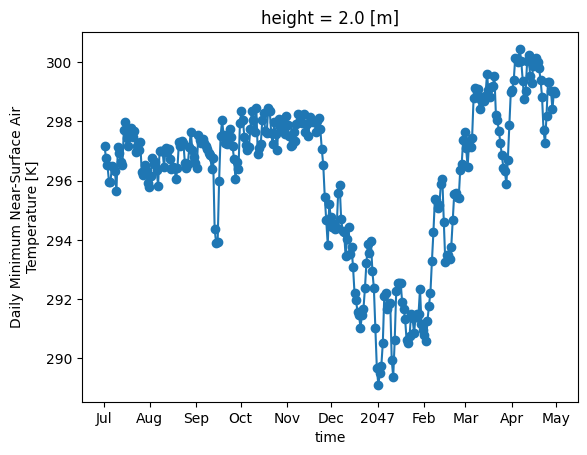

In [9]:
# quick sanity timeseries test for entire country
country = subset.mean(dim=["rlat","rlon"])
country['tasmin'].sel(time=slice('2046-07', '2047-04')).plot(x="time", marker="o", linestyle="-", add_legend=False)

In [10]:
# concat
ds = xr.combine_by_coords(
    datasets, 
    compat='override',
    coords='minimal',
    combine_attrs="override",
)
ds

C:\Users\karimba\AppData\Local\Temp\ipykernel_25816\2634304226.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'scenario' ('scenario',) The recommendation is to set join explicitly for this case.
  ds = xr.combine_by_coords(
C:\Users\karimba\AppData\Local\Temp\ipykernel_25816\2634304226.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'scenario' ('scenario',) The recommendation is to set join explicitly for this case.
  ds = xr.combine_by_coords(
C:\Users\karimba\AppData\Local\Temp\ipykernel_25816\26343042

<xarray.Dataset> Size: 7MB
Dimensions:      (scenario: 2, ensemble: 7, time: 360, rlat: 14, rlon: 13)
Coordinates:
  * scenario     (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble     (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERI...
  * time         (time) datetime64[ns] 3kB 2021-01-01 2021-02-01 ... 2050-12-01
  * rlat         (rlat) float64 112B 6.93 7.15 7.37 7.59 ... 9.13 9.35 9.57 9.79
  * rlon         (rlon) float64 104B -13.09 -12.87 -12.65 ... -10.67 -10.45
    lon          (rlat, rlon) float64 1kB -13.09 -12.87 -12.65 ... -10.67 -10.45
    lat          (rlat, rlon) float64 1kB 6.93 6.93 6.93 6.93 ... 9.79 9.79 9.79
    height       float64 8B 2.0
Data variables:
    tasmin_mean  (scenario, ensemble, time, rlat, rlon) float32 4MB nan ... 2...
    tasmin_min   (scenario, ensemble, time, rlat, rlon) float32 4MB nan ... 2...

In [11]:
# save to disk so can reuse later
ds.to_netcdf('../test_outputs/cordex/cordex_temperature_min_sierra_leone.nc')

## Run from saved output

In [12]:
# open from disk
ds = xr.open_dataset('../test_outputs/cordex/cordex_temperature_min_sierra_leone.nc')

In [13]:
# convert to kelvin
ds = ds - 273.15
ds

<xarray.Dataset> Size: 7MB
Dimensions:      (rlon: 13, rlat: 14, time: 360, scenario: 2, ensemble: 7)
Coordinates:
  * rlon         (rlon) float64 104B -13.09 -12.87 -12.65 ... -10.67 -10.45
  * rlat         (rlat) float64 112B 6.93 7.15 7.37 7.59 ... 9.13 9.35 9.57 9.79
  * time         (time) datetime64[ns] 3kB 2021-01-01 2021-02-01 ... 2050-12-01
  * scenario     (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble     (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERI...
    lon          (rlat, rlon) float64 1kB ...
    lat          (rlat, rlon) float64 1kB ...
    height       float64 8B ...
Data variables:
    tasmin_mean  (scenario, ensemble, time, rlat, rlon) float32 4MB nan ... 1...
    tasmin_min   (scenario, ensemble, time, rlat, rlon) float32 4MB nan ... 1...

In [14]:
ds_ens = xr.Dataset({
    "tasmin_mean_ens_mean": ds['tasmin_mean'].mean(dim="ensemble"),
    "tasmin_mean_ens_min": ds['tasmin_mean'].min(dim="ensemble"),
    "tasmin_mean_ens_max": ds['tasmin_mean'].max(dim="ensemble"),
    "tasmin_min_ens_mean": ds['tasmin_min'].mean(dim="ensemble"),
    "tasmin_min_ens_min": ds['tasmin_min'].min(dim="ensemble"),
    "tasmin_min_ens_max": ds['tasmin_min'].max(dim="ensemble"),
})
ds_ens

<xarray.Dataset> Size: 3MB
Dimensions:               (rlon: 13, rlat: 14, time: 360, scenario: 2)
Coordinates:
  * rlon                  (rlon) float64 104B -13.09 -12.87 ... -10.67 -10.45
  * rlat                  (rlat) float64 112B 6.93 7.15 7.37 ... 9.35 9.57 9.79
  * time                  (time) datetime64[ns] 3kB 2021-01-01 ... 2050-12-01
  * scenario              (scenario) <U5 40B 'rcp26' 'rcp85'
    lon                   (rlat, rlon) float64 1kB -13.09 -12.87 ... -10.45
    lat                   (rlat, rlon) float64 1kB 6.93 6.93 6.93 ... 9.79 9.79
    height                float64 8B 2.0
Data variables:
    tasmin_mean_ens_mean  (scenario, time, rlat, rlon) float32 524kB 26.06 .....
    tasmin_mean_ens_min   (scenario, time, rlat, rlon) float32 524kB 23.85 .....
    tasmin_mean_ens_max   (scenario, time, rlat, rlon) float32 524kB 28.4 ......
    tasmin_min_ens_mean   (scenario, time, rlat, rlon) float32 524kB 24.15 .....
    tasmin_min_ens_min    (scenario, time, rlat, rlon) float32 524kB 20.14 .....
    tasmin_min_ens_max    (scenario, time, rlat, rlon) float32 524kB 27.05 .....

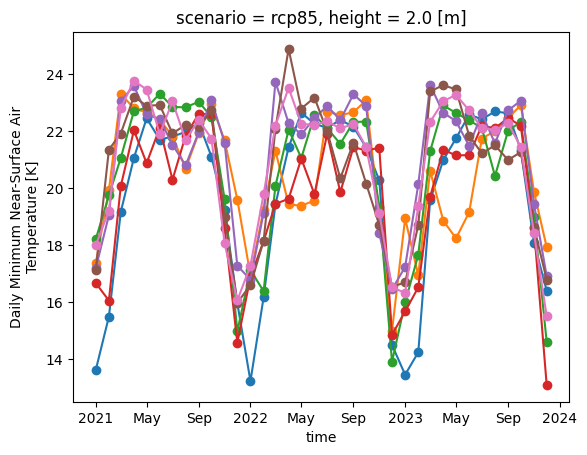

In [17]:
# quick sanity timeseries test for entire country
country = ds.mean(dim=["rlat","rlon"])
country['tasmin_min'].sel(scenario='rcp85', time=slice(None, '2023')).plot(x="time", hue='ensemble', marker="o", linestyle="-", add_legend=False)

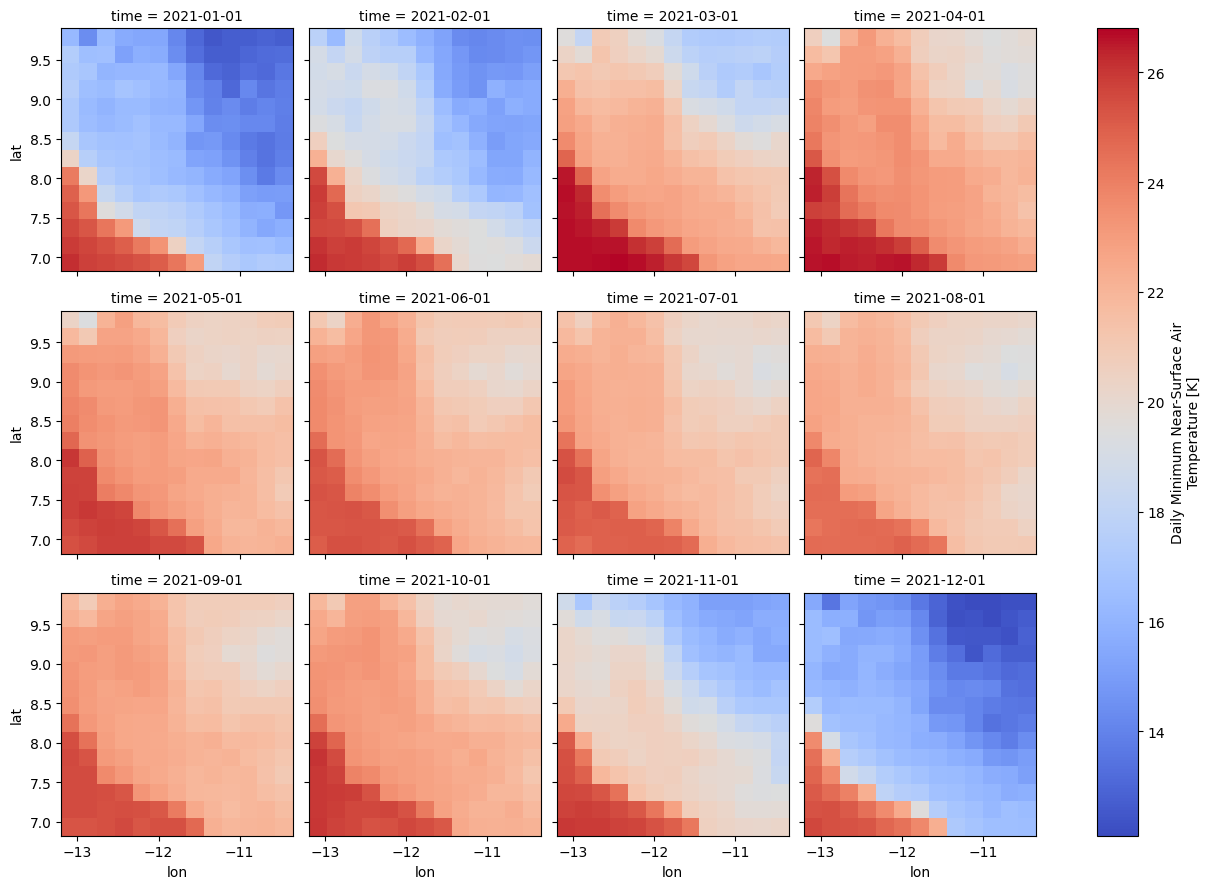

In [18]:
# show months of 2021
grid_means = ds['tasmin_min'].sel(scenario='rcp85').mean(dim='ensemble')
grid_means.isel(time=slice(0, 12)).plot(x="lon", y="lat", col='time', col_wrap=4, cmap="coolwarm")

In [19]:
# VERY IMPORTANT TODO: NOT SURE IF WEIGHTED SPATIAL AVERAGE IS THE WAY TO GO FOR MIN MAX VALUES
# EG IF A CELL HAS 40 CELSIUS BUT ONLY HALF THE CELL LANDS IN THE REGION,
# ...IS IT ACTUALLY CORRECT TO ONLY COUNT 20 DEGREES TOWARDS THE AVG
# MOREOVER, IF AN ORGUNIT IS SO SMALL THAT IT ONLY CONTAINS HALF CELLS,
# ...AND ALL HAVE 40 CELSIUS THEN WE GET ONLY 20 DEG FOR ITS AVG WHICH WOULD BE WRONG

# aggregate with partial overlaps
# TOOD: switch to different library and method
import xagg
ds_renamed = ds_ens.drop_vars(['lon', 'lat']).rename({'rlon':'lon', 'rlat':'lat'})
print(ds_renamed)
weightmap = xagg.pixel_overlaps(ds_renamed, org_units)
aggregated = xagg.aggregate(ds_renamed, weightmap)
ds_org_units = aggregated.to_dataset()[[
    'tasmin_mean_ens_mean', 'tasmin_mean_ens_min', 'tasmin_mean_ens_max', 
    'tasmin_min_ens_mean', 'tasmin_min_ens_min', 'tasmin_min_ens_max', 
    'id',
    ]]
ds_org_units

<xarray.Dataset> Size: 3MB
Dimensions:               (lon: 13, lat: 14, time: 360, scenario: 2)
Coordinates:
  * lon                   (lon) float64 104B -13.09 -12.87 ... -10.67 -10.45
  * lat                   (lat) float64 112B 6.93 7.15 7.37 ... 9.35 9.57 9.79
  * time                  (time) datetime64[ns] 3kB 2021-01-01 ... 2050-12-01
  * scenario              (scenario) <U5 40B 'rcp26' 'rcp85'
    height                float64 8B 2.0
Data variables:
    tasmin_mean_ens_mean  (scenario, time, lat, lon) float32 524kB 26.06 ... ...
    tasmin_mean_ens_min   (scenario, time, lat, lon) float32 524kB 23.85 ... ...
    tasmin_mean_ens_max   (scenario, time, lat, lon) float32 524kB 28.4 ... 1...
    tasmin_min_ens_mean   (scenario, time, lat, lon) float32 524kB 24.15 ... ...
    tasmin_min_ens_min    (scenario, time, lat, lon) float32 524kB 20.14 ... ...
    tasmin_min_ens_max    (scenario, time, lat, lon) float32 524kB 27.05 ... ...
creating polygons for each pixel...
lat/lon bounds no

<xarray.Dataset> Size: 452kB
Dimensions:               (poly_idx: 13, scenario: 2, time: 360)
Coordinates:
  * poly_idx              (poly_idx) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * scenario              (scenario) <U5 40B 'rcp26' 'rcp85'
  * time                  (time) datetime64[ns] 3kB 2021-01-01 ... 2050-12-01
Data variables:
    tasmin_mean_ens_mean  (poly_idx, scenario, time) float64 75kB 18.08 ... 2...
    tasmin_mean_ens_min   (poly_idx, scenario, time) float64 75kB 15.43 ... 2...
    tasmin_mean_ens_max   (poly_idx, scenario, time) float64 75kB 20.7 ... 26.1
    tasmin_min_ens_mean   (poly_idx, scenario, time) float64 75kB 14.54 ... 1...
    tasmin_min_ens_min    (poly_idx, scenario, time) float64 75kB 11.2 ... 15.96
    tasmin_min_ens_max    (poly_idx, scenario, time) float64 75kB 16.54 ... 2...
    id                    (poly_idx) object 104B 'O6uvpzGd5pu' ... 'at6UHUQatSo'

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': 'Poly #0: O6uvpzGd5pu; OU_264; Bo; 2; ImspTQPwCqd'}>)

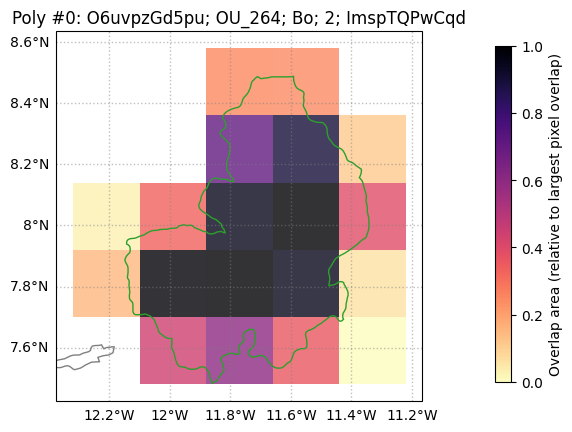

In [20]:
# diagnostic visualization of pixel overlaps
weightmap.diag_fig(0, ds_renamed)

In [21]:
dataframe = ds_org_units.to_dataframe().reset_index()
dataframe

,poly_idx,scenario,time,tasmin_mean_ens_mean,tasmin_mean_ens_min,tasmin_mean_ens_max,tasmin_min_ens_mean,tasmin_min_ens_min,tasmin_min_ens_max,id
0,0,rcp26,2021-01-01,18.084618,15.427096,20.695134,14.538091,11.196980,16.539901,O6uvpzGd5pu
1,0,rcp26,2021-02-01,21.963102,18.284215,25.205120,18.374400,14.242469,22.370408,O6uvpzGd5pu
2,0,rcp26,2021-03-01,23.864894,21.385218,26.366581,21.116129,17.674683,24.032693,O6uvpzGd5pu
3,0,rcp26,2021-04-01,24.345816,23.099077,25.535891,21.924327,19.591140,23.955742,O6uvpzGd5pu
4,0,rcp26,2021-05-01,23.909114,22.787751,24.887173,21.596520,20.418702,23.839369,O6uvpzGd5pu
...,...,...,...,...,...,...,...,...,...,...
9355,12,rcp85,2050-08-01,25.666620,25.012527,27.112958,24.488746,23.570984,26.569586,at6UHUQatSo
9356,12,rcp85,2050-09-01,25.914208,25.184120,27.397520,24.632547,22.803167,26.788124,at6UHUQatSo
9357,12,rcp85,2050-10-01,26.280787,25.472547,27.878973,25.134434,23.919394,27.140599,at6UHUQatSo
9358,12,rcp85,2050-11-01,25.780625,24.495732,27.941764,23.580914,21.590604,26.678161,at6UHUQatSo


## Create metadata

In [24]:
data_elements = [
    {
        "name": "2m Temperature, Lowest Daily (CORDEX RCP 8.5, Ensemble Mean)",
        "shortName": "Temp Lowest - RCP85 Ens Mean",
        "code": "TEMP_MIN_DAILY_MIN_ENS_MEAN_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "MIN",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Lowest Daily (CORDEX RCP 8.5, Ensemble Min)",
        "shortName": "Temp Lowest - RCP85 Ens Min",
        "code": "TEMP_MIN_DAILY_MIN_ENS_MIN_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "MIN",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Lowest Daily (CORDEX RCP 8.5, Ensemble Max)",
        "shortName": "Temp Lowest - RCP85 Ens Max",
        "code": "TEMP_MIN_DAILY_MIN_ENS_MAX_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "MIN",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Average Daily Low (CORDEX RCP 8.5, Ensemble Mean)",
        "shortName": "Temp Avg Low - RCP85 Ens Mean",
        "code": "TEMP_MEAN_DAILY_MIN_ENS_MEAN_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "AVERAGE",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Average Daily Low (CORDEX RCP 8.5, Ensemble Min)",
        "shortName": "Temp Avg Low - RCP85 Ens Min",
        "code": "TEMP_MEAN_DAILY_MIN_ENS_MIN_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "AVERAGE",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Average Daily Low (CORDEX RCP 8.5, Ensemble Max)",
        "shortName": "Temp Avg Low - RCP85 Ens Max",
        "code": "TEMP_MEAN_DAILY_MIN_ENS_MAX_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "AVERAGE",
        "domainType": "AGGREGATE"
    },
]
de_ids = []
for de in data_elements:
    de_created = client.create_data_element(de)
    de_ids.append( de_created['response']['uid'] )
    print(f"Data element creation status: {de_created['status']} and UID: {de_created['response']['uid']}")

Data element creation status: OK and UID: fVlk4Ekmuer
Data element creation status: OK and UID: oUsk1vFP23D
Data element creation status: OK and UID: j20afaPrwwo
Data element creation status: OK and UID: tVqcCI1PXYO
Data element creation status: OK and UID: hQES9F3T7mX
Data element creation status: OK and UID: e2sG9HUSZGQ


In [25]:
data_set = {
    "name": "Monthly CORDEX climate projections", 
    "shortName": "Monthly climate projections",
    "periodType": "Monthly",
    "dataSetElements": [
        {
            "dataElement": {"id": de_id},
        }
        for de_id in de_ids
    ]
}

data_set_created = client.create_data_set(data_set)
print(f"Data set creation status: {data_set_created['status']} and UID: {data_set_created['response']['uid']}")

Data set creation status: OK and UID: HLu9XVMpLl3


## Import to DHIS2

In [26]:
DRY_RUN = 'false'

In [27]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tasmin_min_ens_mean',              # column containing the value
    data_element_id = 'TEMP_MIN_DAILY_MIN_ENS_MEAN_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [28]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tasmin_min_ens_min',              # column containing the value
    data_element_id = 'TEMP_MIN_DAILY_MIN_ENS_MIN_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [29]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tasmin_min_ens_max',              # column containing the value
    data_element_id = 'TEMP_MIN_DAILY_MIN_ENS_MAX_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [30]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tasmin_mean_ens_mean',              # column containing the value
    data_element_id = 'TEMP_MEAN_DAILY_MIN_ENS_MEAN_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [31]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tasmin_mean_ens_min',              # column containing the value
    data_element_id = 'TEMP_MEAN_DAILY_MIN_ENS_MIN_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [32]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tasmin_mean_ens_max',              # column containing the value
    data_element_id = 'TEMP_MEAN_DAILY_MIN_ENS_MAX_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}